# Model Training
- Import data and required libraries

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings


In [38]:
# Importing the data
df = pd.read_csv('data/raw.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0
1,female,group C,some college,standard,completed,69.0,90.0,88.0
2,female,group B,master's degree,standard,none,90.0,95.0,93.0
3,male,group A,associate's degree,free/reduced,none,47.0,57.0,44.0
4,male,group C,some college,standard,none,76.0,78.0,75.0


In [39]:
df.dropna(axis=0,inplace=True)
df

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0
1,female,group C,some college,standard,completed,69.0,90.0,88.0
2,female,group B,master's degree,standard,none,90.0,95.0,93.0
3,male,group A,associate's degree,free/reduced,none,47.0,57.0,44.0
4,male,group C,some college,standard,none,76.0,78.0,75.0
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88.0,99.0,95.0
996,male,group C,high school,free/reduced,none,62.0,55.0,55.0
997,female,group C,high school,free/reduced,completed,59.0,71.0,65.0
998,female,group D,some college,standard,completed,68.0,78.0,77.0


In [40]:
X = df.drop(columns=['math_score'],axis=1)
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72.0,74.0
1,female,group C,some college,standard,completed,90.0,88.0
2,female,group B,master's degree,standard,none,95.0,93.0
3,male,group A,associate's degree,free/reduced,none,57.0,44.0
4,male,group C,some college,standard,none,78.0,75.0


In [41]:
print("Categories in 'gender' variable: ",end=' ')
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable: ",end=' ')
print(df['race_ethnicity'].unique())

print("Categories in 'parental_level_of_education' variable: ",end=' ')
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable: ",end=' ')
print(df['lunch'].unique())

print("Categories in 'test_preparation_course' variable: ",end=' ')
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:  ['female' 'male']
Categories in 'race_ethnicity' variable:  ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental_level_of_education' variable:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:  ['standard' 'free/reduced']
Categories in 'test_preparation_course' variable:  ['none' 'completed']


In [42]:
y = df['math_score']
y

0      72.0
1      69.0
2      90.0
3      47.0
4      76.0
       ... 
995    88.0
996    62.0
997    59.0
998    68.0
999    77.0
Name: math_score, Length: 1000, dtype: float64

In [43]:
# Create Column transformer with 3 types of transformers
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
categoric_transfosrmer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',categoric_transfosrmer,cat_features),
        ('StandardScaler',numeric_transformer,num_features),
    ]
)

In [44]:
X = preprocessor.fit_transform(X)
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [33]:
X.shape

(1000, 19)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

In [48]:
### Create an evaluate function to give all metrics after model training

def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mean_squared_error(true,predicted))
    r2_square = r2_score(true,predicted)
    return mae, rmse, r2_square

In [53]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    # make predictions 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print(" Model performance on training set")
    print(f'Mean absolute error :{model_train_mae:.4f}')
    print(f'- Root mean squared error :{model_test_rmse:.4f}')
    print(f'- R2 Score :{model_train_r2:.4f}')
    
    print('---------------------------------->')
    
    print('Model Performance on Test set')
    print(f'Root Mean squared error : {model_test_rmse:.4f}')
    print(f'Mean absolute error : {model_test_mae:.4f}')
    print(f'R2 Score : {model_test_r2:.4f}')
    
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
 Model performance on training set
Mean absolute error :4.2676
- Root mean squared error :5.3951
- R2 Score :0.8742
---------------------------------->
Model Performance on Test set
Root Mean squared error : 5.3951
Mean absolute error : 4.2154
R2 Score : 0.8804


Lasso
 Model performance on training set
Mean absolute error :5.2063
- Root mean squared error :6.5197
- R2 Score :0.8071
---------------------------------->
Model Performance on Test set
Root Mean squared error : 6.5197
Mean absolute error : 5.1579
R2 Score : 0.8253


Ridge
 Model performance on training set
Mean absolute error :4.2650
- Root mean squared error :5.3904
- R2 Score :0.8743
---------------------------------->
Model Performance on Test set
Root Mean squared error : 5.3904
Mean absolute error : 4.2111
R2 Score : 0.8806


K-Neighbors Regressor
 Model performance on training set
Mean absolute error :4.5167
- Root mean squared error :7.2530
- R2 Score :0.8555
---------------------------------->
Mode

In [54]:
pd.DataFrame(list(zip(model_list,r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'],ascending=False)

,Model Name,R2 Score
2,Ridge,0.880593
0,Linear Regression,0.880383
5,Random Forest Regressor,0.852335
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.851167
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.734012


In [55]:
# Linear Regression
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


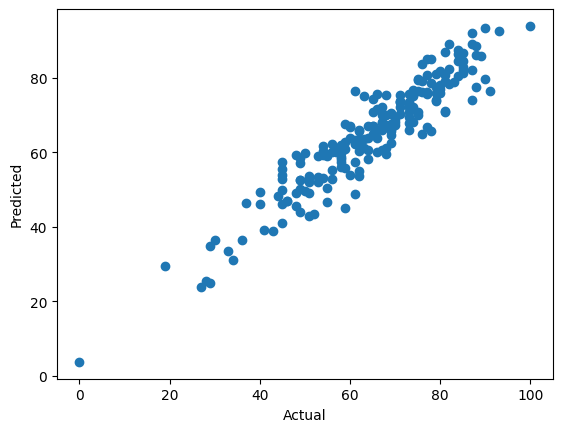

In [56]:
# Plotting y_test , y_pred
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

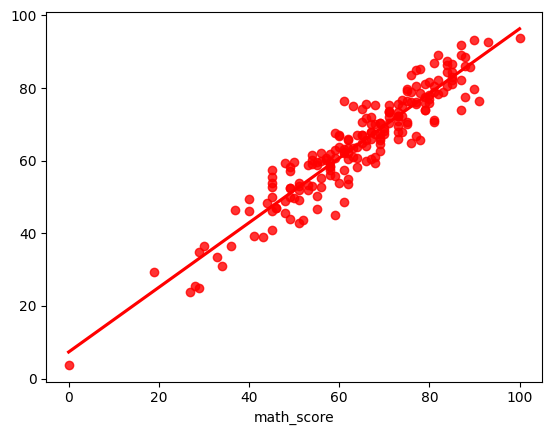

In [57]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [58]:
# Diff between actual and predicted values
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91.0,76.500000,14.500000
737,53.0,58.945312,-5.945312
740,80.0,76.953125,3.046875
660,74.0,76.757812,-2.757812
411,84.0,87.531250,-3.531250
...,...,...,...
408,52.0,43.546875,8.453125
332,62.0,62.015625,-0.015625
208,74.0,67.968750,6.031250
613,65.0,67.132812,-2.132812
